# Test `MDCGaussianNoise`

This notebook tests the class `MDCGaussianNoise` implemented in `likelihood.py`.

**Input needed by `MDCGaussianNoise`:**
* data : the data segment that we want to analyze. The format should be a dict() where each key represents one detector. The data for each detector should be a pycbc FrequencySeries.
* psd : the PSD of the noise (can be estimated or provided, for the moment we just provide it). Same format as *data*.

Use `data, psd = get_data.convert_to_frequency_series_with_psd(time_series, return_psd=True)` to get data and psd with the correct format from a dictionary containing gwpy time series read .gwf files.

* variable_params : a list of parameters over which we want to maximize. In the most general case it should be ['mass1', 'mass2', 'spin1z', 'spin2z', 'distance', 'polarization', 'inclination', 'tc', 'coa_phase', 'ra', 'dec'], but it is possible to reduce the number of variable parameters to make tests for example.
* static_params : a dictionary containing the parameters for which the values are already fixed (in general the spins along the x and y axes).

Note that all 15 CBC parameters must be defined, either in *variable_params* or in *static_params*.

* approximant and fmin should be defined (the default values 'IMRPhenomXPHM' and 5 Hz are fine).

**Optional input:** these are just for testing to compare the values of the parameters we recover to the injected values.
* injection_params : a dictionary contaning the parameters of the injected signal if we know them.
* injection_network_snr : the network SNR of the signal, as listed in the list of MDC signal (2nd column from the end).

**Input needed by `maximize`:**
For each variable parameter, bounds must be provided.

*Warning:* mass1 and mass2 bounds should be replaced with chirp mass and mass ratio.

## Example of workflow

1. Read MDC data using `get_data.read_MDC_data()` (for example data around a signal with high SNR).
2. Prepare frequency domain data and PSD using `get_data.convert_to_frequency_series_with_psd()`.
3. Define variable and static params.
4. Instanciate a MDCGaussianNoise object.
5. Define bounds for each variable parameter.
6. Run `maximize()`.
7. Compare recovered parameters to injected ones, if they are known. Compare recovered log likelihood ratio to injected network SNR if it is known.
8. Run reconstruct_signal(), then subtract_signal() and compare the original data and the reconstructed signal.

In [1]:
from generate_data import generate_frequency_domain_signal, default_cbc_params
from get_data import get_psd_frequency_series, read_MDC_data, convert_to_frequency_series_with_psd, convert_data_dict_to_frequency_series_dict
from likelihood import MDCGaussianNoise, subtract_signal
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['font.size'] = 12  # global font size
import numpy as np
from gwpy.timeseries import TimeSeries
from pycbc.types import FrequencySeries

/home/victor/miniconda3/envs/pycbc_env/lib/python3.9/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## 1 - Generate signal

First we generate a signal (in the frequency domain) using the functions defined in `generate_signal.py`.

In [10]:
cbc_params = {
              'mass1': 38.6,
              'mass2': 29.3,
              'spin1x': 0., 'spin2x': 0.,  'spin1y': 0., 'spin2y': 0.,  'spin1z': 0, 'spin2z': 0, 
              'eccentricity': 0,
              'ra': 1.37, 'dec': -1.26, 'distance': 10000, 
              'polarization': 2.76, 'inclination': 0,
              'tc': 3.1 , 'coa_phase': 0.3,
              'approximant': 'IMRPhenomXPHM',
              'f_lower': 5
                }
signal = generate_frequency_domain_signal(cbc_params, ifos=['E1', 'E2', 'E3'])
print(signal)

Waveform approximate duration: 31.9s
Segment duration: 64.0s
{'E1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7470ef7c9b80>, 'E2': <pycbc.types.frequencyseries.FrequencySeries object at 0x7470ef14cb20>, 'E3': <pycbc.types.frequencyseries.FrequencySeries object at 0x7470ece4d8e0>}


In [3]:
data = read_MDC_data(1001620399.26659, 1001620463.11925)
print(data)

data['E1'].write("/home/victor-glorieux/Internship_Victor_CBC_ET/code_Adrian/MLE_pipeline/data/données_E1.txt")
data['E2'].write("/home/victor-glorieux/Internship_Victor_CBC_ET/code_Adrian/MLE_pipeline/data/données_E2.txt")
data['E3'].write("/home/victor-glorieux/Internship_Victor_CBC_ET/code_Adrian/MLE_pipeline/data/données_E3.txt")

fft, psd = convert_to_frequency_series_with_psd(data['E1'], return_psd=True)
data_freq, psds = convert_data_dict_to_frequency_series_dict(data)
model = MDCGaussianNoise(data_freq, psds)
print(model.lognl)

{'E1': <TimeSeries([-2.16874926e-23, -2.02161776e-23, -1.74414906e-23,
             ...,  8.89037920e-23, -6.39292277e-23,
              7.44417807e-23]
            unit=Unit("strain"),
            t0=<Quantity 1.0016204e+09 s>,
            dt=<Quantity 0.00024414 s>,
            name='E1:STRAIN',
            channel=<Channel("E1:STRAIN", 8192.0 Hz) at 0x7f6837364280>)>, 'E2': <TimeSeries([-2.90205761e-23,  3.76218612e-23, -5.79038990e-23,
             ...,  4.75558006e-23, -2.85348704e-23,
              6.35862733e-23]
            unit=Unit("strain"),
            t0=<Quantity 1.0016204e+09 s>,
            dt=<Quantity 0.00024414 s>,
            name='E2:STRAIN',
            channel=<Channel("E2:STRAIN", 8192.0 Hz) at 0x7f68dc0ef550>)>, 'E3': <TimeSeries([ 4.31007369e-23, -1.93298835e-23,  1.61201235e-23,
             ...,  6.02385021e-24, -2.26833544e-23,
             -6.12309151e-25]
            unit=Unit("strain"),
            t0=<Quantity 1.0016204e+09 s>,
            dt=<Quantity 

In [11]:
from pycbc.types import FrequencySeries
from pycbc.types import TimeSeries as PycbcTimeSeries

path_data = '/home/victor/Internship_Victor_CBC_ET/code_Adrian/MLE_pipeline/data/'
data = {}
signal = {}
ifos=['E1', 'E2', 'E3']
for ifo in ifos:
    channel = ifo + ':STRAIN'
    file = path_data + 'données_' + ifo + '.txt'
    data[ifo] = TimeSeries.read(file)
    data[ifo] = data[ifo].resample(4096)
    val = data[ifo].value
    delta_t = data[ifo].dt.value
    pycbc_ts = PycbcTimeSeries(val, delta_t=delta_t)
    signal[ifo] = pycbc_ts.to_frequencyseries()
     

fft, psd = convert_to_frequency_series_with_psd(data['E1'], return_psd=True)
data_freq, psds = convert_data_dict_to_frequency_series_dict(data)
print(data_freq)
print(psds)

/home/victor/miniconda3/envs/pycbc_env/lib/python3.9/site-packages/gwpy/timeseries/timeseries.py:930: UserWarning: resample() rate matches current sample_rate (4096.0 Hz), returning input data unmodified; please double-check your parameters
  warnings.warn(


{'E1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7470f4354790>, 'E2': <pycbc.types.frequencyseries.FrequencySeries object at 0x7470ed9a3df0>, 'E3': <pycbc.types.frequencyseries.FrequencySeries object at 0x7470ed9a3fa0>}
{'E1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7470ef14cc70>, 'E2': <pycbc.types.frequencyseries.FrequencySeries object at 0x74712754c8b0>, 'E3': <pycbc.types.frequencyseries.FrequencySeries object at 0x74712754c550>}


In [12]:
model = MDCGaussianNoise(data_freq, psds)
print(model.lognl)

-540823.333542688


## 2 - Create MDCGaussianNoise model

We instanciate an MDCGaussianNoise object with the signal we have generated and the PSD used for the ET MDC.

Since there is no noise, we verify that the optimal log likelihood is 0 and the optimal log likelihood ratio corresponds to 1/2 of the network SNR. Here "optimal" means "computed for the true parameters of the injected CBC signal".

**Variable and static parameters:**
* Variable parameters are the ones that we want to maximize over. They are provided as a list.
* Static parameters are fixed: they are provided as a dictionary with known values.

All CBC parameters defined in *cbc_params* must be either in *variable_params* or defined in *static_params*. The approximant and lower frequency are always static.

In [14]:
#psd = get_psd_frequency_series(signal['E1'].get_sample_frequencies(), signal['E1'].get_delta_f())
#psds = {'E1': psd, 'E2': psd, 'E3': psd}

cbc_params = {
              'mass1': 38.6,
              'mass2': 29.3,
              'spin1x': 0., 'spin2x': 0.,  'spin1y': 0., 'spin2y': 0.,  'spin1z': 0, 'spin2z': 0, 
              'eccentricity': 0,
              'ra': 1.37, 'dec': -1.26, 'distance': 10000, 
              'polarization': 2.76, 'inclination': 0,
              'tc': 3.1 , 'coa_phase': 0.3,
              'approximant': 'IMRPhenomXPHM',
              'f_lower': 5
                }

variable_params = ['mass1', 'mass2','spin1z', 'spin2z', 'ra', 'dec', 'distance', 'polarization', 'inclination', 'tc', 'coa_phase']
static_params = dict(cbc_params)
for param in variable_params :
    del static_params[param]


# injection_params=cbc_params deleted
# We know the signal parameters so we can define injection_params and compute optimal likelihoods
model = MDCGaussianNoise(signal, psds, fmin=5, approximant='IMRPhenomXPHM', variable_params=variable_params,\
                         static_params=static_params, injection_network_snr=1240.9)

optimal_loglr, optimal_loglikelihood = model.compute_optimal_likelihoods()
print('Optimal log likelihood ratio: ' + format(optimal_loglr, '.2f'))
print('Optimal log likelihood: ' + format(optimal_loglikelihood, '.2f'))

#snr_network_sq = model.det_optimal_snrsq('E1') + model.det_optimal_snrsq('E2') + model.det_optimal_snrsq('E3')
#print('1/2 network SNR: ' + format(0.5 * snr_network_sq, '.2f'))

True signal parameters unknown. Cannot compute optimal likelihood.
Optimal log likelihood ratio: -1.00
Optimal log likelihood: -1.00


## 3 - Maximize the likelihood

The method `maximize()` calls `scipy.optimize.differential_evolution()`. We can specify the maximal number of iterations and the tolerance, which are parameters of `differential_evolution()`. This method automatically defines the bounds on the parameters over which to maximize, with a radius of 10% from the true values (for example if the true chirp mass is 30, it will restrict the chirp mass in the range 27, 33). When doing the full analysis of the MDC, we will use greater bounds since we are not supposed to know the true values of the injected signal.

In [15]:
pi2 = 2*np.pi
mc_bound = (28, 30)
q_bound = (1,2)
spin1z_bound = (-0.97,0.97)
spin2z_bound = (-0.97,0.97)
distance_bound = (10,10000)
ra_bound = (0,np.pi)
dec_bound = (-pi2,pi2)
pola_bound = (0,np.pi)
incl_bound = (0,np.pi)
tc_bound = (1001620450,1001620463)
phase_bound = (0, pi2)
bounds = [mc_bound, q_bound,spin1z_bound,spin2z_bound,ra_bound,dec_bound,distance_bound,pola_bound,incl_bound,tc_bound,phase_bound]

res = model.maximize(bounds, max_iterations=20, tol=1e-6)
print(model.maximized_params)
print(model.injection_params)

Start maximization over the following parameters:
('mass1', 'mass2', 'spin1z', 'spin2z', 'ra', 'dec', 'distance', 'polarization', 'inclination', 'tc', 'coa_phase')


KeyboardInterrupt: 

## 4 - Reconstruct the signal and compare with the injected signal

The method reconstruct_signal() builds a signal from the maximized parameters. We can then translate it in the time domain and compare with the true injected signal.

In [5]:
signal_reconstructed_f, signal_reconstructed_t = model.reconstruct_signal()

Waveform approximate duration: 31.9s
Segment duration: 64.0s


In [6]:
original_time_domain_signals = {'E1': model.data['E1'].to_timeseries(),
                                'E2': model.data['E2'].to_timeseries(),
                                'E3': model.data['E3'].to_timeseries(),
                               }
residuals = subtract_signal(original_time_domain_signals, signal_reconstructed_t)

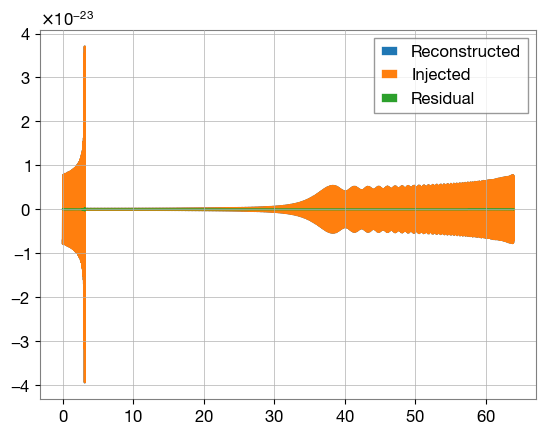

In [7]:

plt.figure()
ax = plt.gca()
ax.plot(signal_reconstructed_t['E1'].get_sample_times(), signal_reconstructed_t['E1'], label='Reconstructed')
ax.plot(original_time_domain_signals['E1'].get_sample_times(), original_time_domain_signals['E1'], label='Injected')
ax.plot(residuals['E1'].get_sample_times(), residuals['E1'], label='Residual')

ax.legend()


### Computing time

* The longer the signal is, the longer it takes to generate it and therefore maximize the likelihood. CBC signals become longer when we decrease the minimal frequency and/or the chirp mass.
* For the ET MDC, we would ideally want to go down to a minimal frequency of 5 Hz and chirp mass of 1.21 solar masses. In this case the signal lasts more than 6000s. It is possible that it takes too much computing time. If that's the case, we could decide to increase the minimal frequency to keep the computing cost manageable.